<a href="https://colab.research.google.com/github/WCosmo/ENCOM_2023-Modelo_de_descarga/blob/main/ENCOM_2023_-_Modelo_de_descarga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

Projeto destinado à participação no ENCOM 2023.

Resumo: Extrair dados provenientes de um cenário proposto de rede IoT, que consiste dos valores de uma bateria recarregável acoplado ao end-node, que pode estar conectado a diferentes sensores que irão gerar diferentes consumos de energia. A partir desses dados, treinar modelos RNA para estimar o tempo a partir de um segmento observado até o ponto de descarga.

Autor: Wilson Cosmo

Bibliotecas nescessárias:

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras import models
from sklearn.model_selection import train_test_split

#1 - Carregamento dos dados .csv da API Thingspeak


In [82]:
data1 = pd.read_csv('https://raw.githubusercontent.com/WCosmo/ENCOM_2023-Modelo_de_descarga/main/base_de_dados/thingspeak_canal_01.csv')
data2 = pd.read_csv('https://raw.githubusercontent.com/WCosmo/ENCOM_2023-Modelo_de_descarga/main/base_de_dados/thingspeak_canal_02.csv')

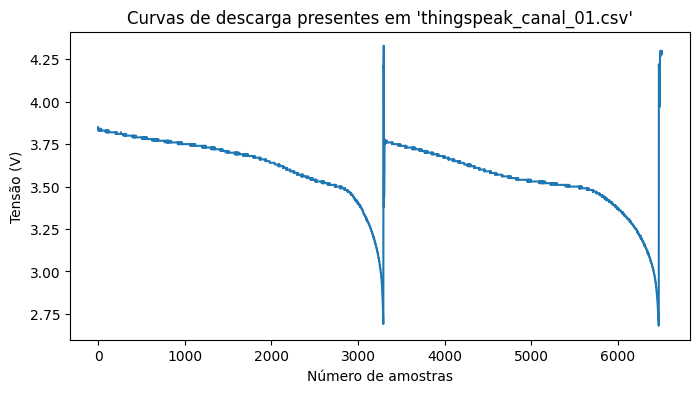

In [83]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(data1['field2'].to_numpy())
plt.title('Curvas de descarga presentes em \'thingspeak_canal_01.csv\'')
plt.xlabel('Número de amostras')
plt.ylabel('Tensão (V)')
plt.show()

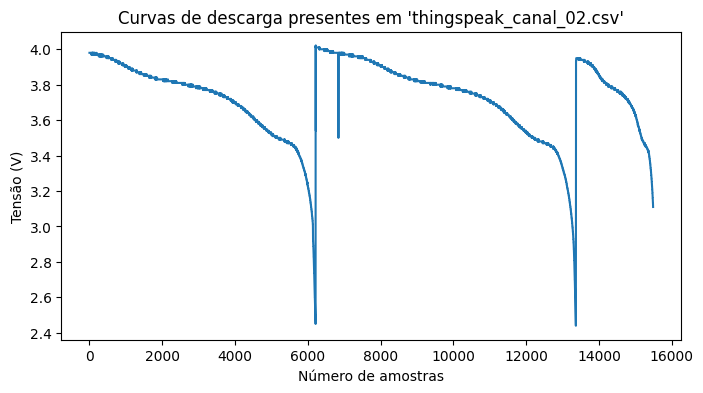

In [84]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(data2['field2'].to_numpy())
plt.title('Curvas de descarga presentes em \'thingspeak_canal_02.csv\'')
plt.xlabel('Número de amostras')
plt.ylabel('Tensão (V)')
plt.show()

#2 - Pré-processamento e visualização

Cada curva de descarga está associada a uma "tag" na API da Thingspeak, a seguir divide-se os dados separando as curvas em vetores:

In [85]:
timestamp_e1 = []
timestamp_e2 = []
timestamp_e3 = []

d_curve_e1 = []
d_curve_e2 = []
d_curve_e3 = []

for i in range(len(data2['field1'].to_numpy())):
  if data2['field2'].to_numpy()[i] < 3.7 and data2['field2'].to_numpy()[i] > 2.75 :
    if data2['field1'].to_numpy()[i] == 1: #Retornar apenas o experimento 1
      timestamp_e1.append(data2['created_at'][i])
      d_curve_e1.append(data2['field2'].to_numpy()[i])
    if data2['field1'].to_numpy()[i] == 2: #Retornar apenas o experimento 3
      timestamp_e3.append(data2['created_at'][i])
      d_curve_e3.append(data2['field2'].to_numpy()[i])

for i in range(len(data1['field1'].to_numpy())):
  if data1['field2'].to_numpy()[i] < 3.7 and data1['field2'].to_numpy()[i] > 2.75 :
    if data1['field1'].to_numpy()[i] == 2: #Retornar apenas o experimento 2
      timestamp_e2.append(data1['created_at'][i])
      d_curve_e2.append(data1['field2'].to_numpy()[i])

d_curve_e1 = np.array(d_curve_e1)
d_curve_e2 = np.array(d_curve_e2)
d_curve_e3 = np.array(d_curve_e3)

Plot "bruto" das curvas de descarga:

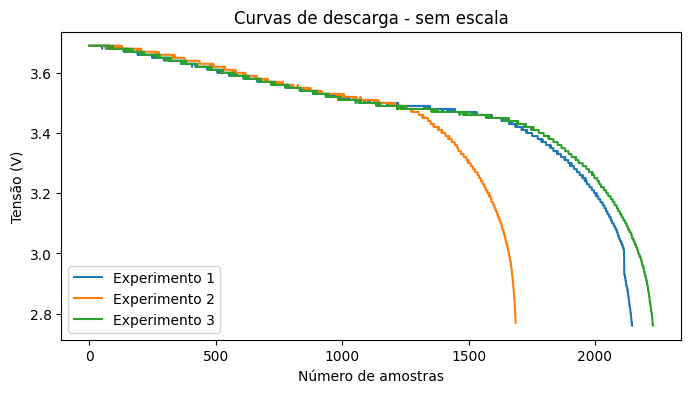

In [86]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(d_curve_e1, label='Experimento 1')
plt.plot(d_curve_e2, label='Experimento 2')
plt.plot(d_curve_e3[2:], label='Experimento 3')

plt.legend(loc='lower left')
plt.title('Curvas de descarga - sem escala')
plt.xlabel('Número de amostras')
plt.ylabel('Tensão (V)')
plt.show()

Função para transformar o timestamp no formato "yyyy/mm/dd-hh:mm:ss" para apenas segundo, que é a menor unidade de tempo presente no timestamp:

In [87]:
def timestamper(timestamp):

  ft = 0
  ii = 0
  timescale = []

  for t in timestamp:
    sbuff = t.split('T')
    s_ymd = sbuff[0].split('-')
    ymd = int(s_ymd[0])*31536000 + int(s_ymd[1])*2592000 + int(s_ymd[2])*86400 #converter yyyy/mm/dd para s

    bs_hr = sbuff[1].split('-')
    s_hr = bs_hr[0].split(':')
    hr = int(s_hr[0])*3600 + int(s_hr[1])*60 + int(s_hr[2]) #converter hh:mm:ss para s

    ts = ymd + hr
    timescale.append(ts)


  timescale = np.array(timescale)
  return timescale - min(timescale)

In [88]:
t_e1 = timestamper(timestamp_e1[:])
t_e2 = timestamper(timestamp_e2[:])
t_e3 = timestamper(timestamp_e3[2:])

Plot das curvas de descarga com a escala de tempo correspondente:

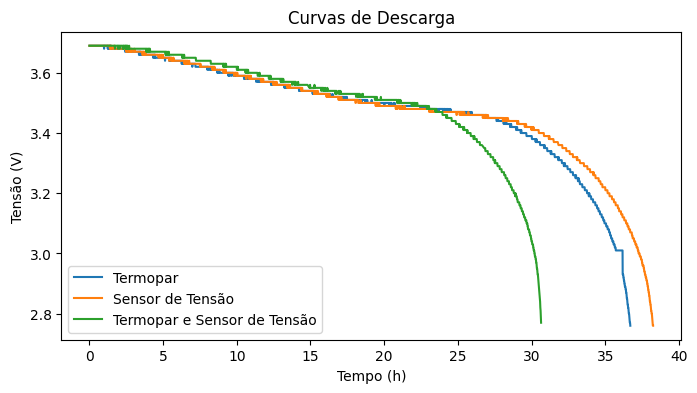

In [89]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(t_e1/(60*60),d_curve_e1, label='Termopar')
plt.plot(t_e3/(60*60),d_curve_e3[2:], label='Sensor de Tensão')
plt.plot(t_e2/(60*60),d_curve_e2, label='Termopar e Sensor de Tensão')
plt.legend(loc='lower left')
plt.title('Curvas de Descarga')
plt.xlabel('Tempo (h)')
plt.ylabel('Tensão (V)')
plt.show()

#3 - Definição das bases de dados

Exemplo da lógica utilizada para criar as instâncias para as bases de dados, observando um segmento da curva de descarga. O número de pontos que compõe o segmento corresponde ao número de neurônios de entrada, e o tempo restante do último ponto do segmento até o ponto de descarga é o valor de saída (Plot a seguir ilustrativo).

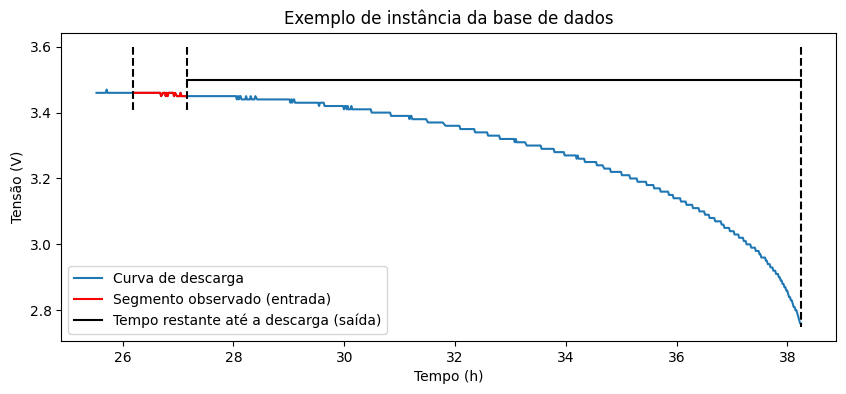

In [90]:
plt.rcParams['figure.figsize'] = (10, 4)
plt.plot(t_e3[1500:]/(60*60),d_curve_e3[1502:], label='Curva de descarga')
plt.plot(t_e3[1540:1570+20]/(60*60), d_curve_e3[1542:1572+20],'r-', label='Segmento observado (entrada)')
plt.plot([t_e3[1540]/(60*60),t_e3[1540]/(60*60)],[3.6,3.4], 'k--')
plt.plot([t_e3[1570+20]/(60*60),t_e3[2230]/(60*60)],[3.5,3.5], 'k', label='Tempo restante até a descarga (saída)')
plt.plot([t_e3[1570+20]/(60*60),t_e3[1570+20]/(60*60)],[3.6,3.4], 'k--')
plt.plot([t_e3[2230]/(60*60),t_e3[2230]/(60*60)],[3.6,2.75], 'k--')
plt.legend(loc='lower left')
plt.title('Exemplo de instância da base de dados')
plt.xlabel('Tempo (h)')
plt.ylabel('Tensão (V)')
plt.show()

Função que gera instâncias a partir de um número de pontos (tamantnho do segmento observado):

In [91]:
def gen_dataset(curve, ts, pn):
  ll = len(curve)

  X = np.zeros((ll-pn, pn))
  Y = np.zeros(ll-pn)

  for i in range(ll-pn):
    for j in range(pn):
      X[i][pn-j-1] = curve[pn+i-j-1]


  Y = ts[pn:]
  Y = max(Y) - Y

  return (X,Y)

In [92]:
def norm(v, mi, ma):
  n_v = (v-mi)/(ma-mi)

  return n_v

In [93]:
def de_norm(n_v, mi, ma):
  v = ((n_v)*(ma-mi))+mi

  return v

Considera-se o intervalo da curva de descarga entre 3.7v a 2.75v

In [94]:
X_min = 2.75
X_max = 3.70

Y_min = min(np.concatenate((t_e1,t_e2,t_e3)))
Y_max = max(np.concatenate((t_e1,t_e2,t_e3)))

#4 - Definição e treino dos Modelos RNA

Número de épocas para o treino dos modelos:

In [95]:
ep = 100

Foram testados quatro tamanhos de segmentos:

- 5 pontos
- 10 pontos
- 15 pontos
- 20 pontos

Foram testados 5 diferentes tipos de modelos de RNA para cada tamanho de segmento:

- Modelo 1: 2 camadas Feed-Forward (FFW)
- Modelo 2: 2 camadas Gated recurrent units (GRU)
- Modelo 3: 2 camadas Long short-term memory (LSTM)
- Modelo 4: 2 camadas Rede Neural Convolucional (CNN)
- Modelo 5: 1 camada CNN + 1 camada LSTM

4.1. Estimagem a partir de segmentos de 5 pontos

In [96]:
n_5p = 5

d1_5p = gen_dataset(norm(d_curve_e1, X_min, X_max), norm(t_e1, Y_min, Y_max), n_5p)
d1_5pX_train, d1_5pX_test, d1_5pY_train, d1_5pY_test = train_test_split(d1_5p[0], d1_5p[1], test_size=0.2, random_state=6)

d2_5p = gen_dataset(norm(d_curve_e2, X_min, X_max), norm(t_e2, Y_min, Y_max), n_5p)
d2_5pX_train, d2_5pX_test, d2_5pY_train, d2_5pY_test = train_test_split(d2_5p[0], d2_5p[1], test_size=0.2, random_state=6)

X_5p = pd.DataFrame(np.concatenate((d1_5pX_train, d2_5pX_train)))
Y_5p = pd.DataFrame(np.concatenate((d1_5pY_train, d2_5pY_train)))

X_5p_t = pd.DataFrame(np.concatenate((d1_5pX_test, d2_5pX_test)))
Y_5p_t = pd.DataFrame(np.concatenate((d1_5pY_test, d2_5pY_test)))

d3_5p = gen_dataset(norm(d_curve_e3[2:], X_min, X_max), norm(t_e3, Y_min, Y_max), n_5p)

m1_results = []

FFW

In [97]:
model_5p_1 = keras.models.Sequential()
model_5p_1.add(keras.layers.Flatten(input_shape=[n_5p]))

#1st fully connected Neural Network hidden-layer
model_5p_1.add(keras.layers.Dense(30))
model_5p_1.add(keras.layers.Dropout(0.3))
model_5p_1.add(keras.layers.Activation('relu'))

#2nd fully connected Neural Network hidden-layer
model_5p_1.add(keras.layers.Dense(30))
model_5p_1.add(keras.layers.Dropout(0.3))
model_5p_1.add(keras.layers.Activation('relu'))

#Output layer
model_5p_1.add(keras.layers.Dense(1, activation="sigmoid"))
model_5p_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 30)                180       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 activation (Activation)     (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 activation_1 (Activation)   (None, 30)                0

In [98]:
model_5p_1.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h51 = model_5p_1.fit(X_5p, Y_5p, epochs=ep, batch_size=8)

Epoch 1/100
383/383 [==============================] - 2s 2ms/step - loss: 0.0636 - mse: 0.0636
Epoch 2/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0333 - mse: 0.0333
Epoch 3/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0184 - mse: 0.0184
Epoch 4/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0140 - mse: 0.0140
Epoch 5/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0130 - mse: 0.0130
Epoch 6/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0123 - mse: 0.0123
Epoch 7/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0116 - mse: 0.0116
Epoch 8/100
383/383 [==============================] - 1s 3ms/step - loss: 0.0113 - mse: 0.0113
Epoch 9/100
383/383 [==============================] - 1s 3ms/step - loss: 0.0110 - mse: 0.0110
Epoch 10/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0107 - mse: 0.0107
Epoch 11/100
383/383 [=================

In [99]:
m1_results.append(('FFW 1', model_5p_1.evaluate(X_5p_t, Y_5p_t, verbose=1)[1]))
m1_results.append(('FFW 2', model_5p_1.evaluate(d3_5p[0], d3_5p[1], verbose=1)[1]))

70/70 [==============================] - 0s 2ms/step - loss: 0.0139 - mse: 0.0139


GRU

In [100]:
model_5p_2 = keras.models.Sequential()

#1st Layer - GRU
model_5p_2.add(keras.layers.GRU(30, return_sequences=True, activation='relu', input_shape=(n_5p, 1)))

#2nd Layer - GRU
model_5p_2.add(keras.layers.GRU(30, activation='relu'))

#Output layer
model_5p_2.add(keras.layers.Dense(1, activation="sigmoid"))
model_5p_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 30)             2970      
                                                                 
 gru_1 (GRU)                 (None, 30)                5580      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________


In [101]:
model_5p_2.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h52 = model_5p_2.fit(X_5p, Y_5p, epochs=ep, batch_size=8)

Epoch 1/100
383/383 [==============================] - 7s 8ms/step - loss: 0.0286 - mse: 0.0286
Epoch 2/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0084 - mse: 0.0084
Epoch 3/100
383/383 [==============================] - 3s 9ms/step - loss: 0.0083 - mse: 0.0083
Epoch 4/100
383/383 [==============================] - 3s 9ms/step - loss: 0.0080 - mse: 0.0080
Epoch 5/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0081 - mse: 0.0081
Epoch 6/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0082 - mse: 0.0082
Epoch 7/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0080 - mse: 0.0080
Epoch 8/100
383/383 [==============================] - 4s 10ms/step - loss: 0.0081 - mse: 0.0081
Epoch 9/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0080 - mse: 0.0080
Epoch 10/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0079 - mse: 0.0079
Epoch 11/100
383/383 [================

In [102]:
m1_results.append(('GRU 1', model_5p_2.evaluate(X_5p_t, Y_5p_t, verbose=1)[1]))
m1_results.append(('GRU 2', model_5p_2.evaluate(d3_5p[0], d3_5p[1], verbose=1)[1]))

70/70 [==============================] - 1s 3ms/step - loss: 0.0143 - mse: 0.0143


LSTM

In [103]:
model_5p_3 = keras.models.Sequential()

#1st Layer - LSTM
model_5p_3.add(keras.layers.LSTM(30, return_sequences=True, activation='relu', input_shape=(n_5p, 1)))

#2nd Layer - LSTM
model_5p_3.add(keras.layers.LSTM(30, activation='relu'))

#Output layer
model_5p_3.add(keras.layers.Dense(1, activation="sigmoid"))
model_5p_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 30)             3840      
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [104]:
model_5p_3.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h53 = model_5p_3.fit(X_5p, Y_5p, epochs=ep, batch_size=8)

Epoch 1/100
383/383 [==============================] - 5s 7ms/step - loss: 0.0349 - mse: 0.0349
Epoch 2/100
383/383 [==============================] - 3s 9ms/step - loss: 0.0086 - mse: 0.0086
Epoch 3/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0082 - mse: 0.0082
Epoch 4/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0081 - mse: 0.0081
Epoch 5/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0081 - mse: 0.0081
Epoch 6/100
383/383 [==============================] - 2s 7ms/step - loss: 0.0081 - mse: 0.0081
Epoch 7/100
383/383 [==============================] - 4s 9ms/step - loss: 0.0079 - mse: 0.0079
Epoch 8/100
383/383 [==============================] - 2s 6ms/step - loss: 0.0080 - mse: 0.0080
Epoch 9/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0079 - mse: 0.0079
Epoch 10/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0080 - mse: 0.0080
Epoch 11/100
383/383 [=================

In [105]:
m1_results.append(('LSTM 1', model_5p_3.evaluate(X_5p_t, Y_5p_t, verbose=1)[1]))
m1_results.append(('LSTM 2', model_5p_3.evaluate(d3_5p[0], d3_5p[1], verbose=1)[1]))

70/70 [==============================] - 1s 4ms/step - loss: 0.0099 - mse: 0.0099


CNN

In [106]:
model_5p_4 = keras.models.Sequential()
model_5p_4.add(keras.layers.Reshape((n_5p, 1), input_shape=(n_5p,)))

#1st layer - CNN
model_5p_4.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_5p_4.add(keras.layers.MaxPooling1D(2))
model_5p_4.add(keras.layers.Reshape((30,1)))

#2nd layer - CNN
model_5p_4.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_5p_4.add(keras.layers.MaxPooling1D(2))
model_5p_4.add(keras.layers.Flatten())

#Output layer
model_5p_4.add(keras.layers.Dense(1, activation='sigmoid'))
model_5p_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 5, 1)              0         
                                                                 
 conv1d (Conv1D)             (None, 3, 30)             120       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 30)            0         
 )                                                               
                                                                 
 reshape_1 (Reshape)         (None, 30, 1)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 30)            120       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 14, 30)           0         
 1D)                                                  

In [107]:
model_5p_4.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h54 = model_5p_4.fit(X_5p, Y_5p, epochs=ep, batch_size=8)

Epoch 1/100
383/383 [==============================] - 2s 2ms/step - loss: 0.0511 - mse: 0.0511
Epoch 2/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0124 - mse: 0.0124
Epoch 3/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 4/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 5/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0078 - mse: 0.0078
Epoch 6/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0078 - mse: 0.0078
Epoch 7/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0078 - mse: 0.0078
Epoch 8/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0078 - mse: 0.0078
Epoch 9/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0080 - mse: 0.0080
Epoch 10/100
383/383 [==============================] - 1s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 11/100
383/383 [=================

In [108]:
m1_results.append(('CNN 1', model_5p_4.evaluate(X_5p_t, Y_5p_t, verbose=1)[1]))
m1_results.append(('CNN 2', model_5p_4.evaluate(d3_5p[0], d3_5p[1], verbose=1)[1]))

70/70 [==============================] - 0s 2ms/step - loss: 0.0106 - mse: 0.0106


CNN + LSTM

In [109]:
model_5p_5 = keras.models.Sequential()
model_5p_5.add(keras.layers.Reshape((n_5p, 1), input_shape=(n_5p,)))

#1st layer - CNN
model_5p_5.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_5p_5.add(keras.layers.MaxPooling1D(2))

#2nd layer - LSTM
model_5p_5.add(keras.layers.Flatten())
model_5p_5.add(keras.layers.Reshape((1, 30)))
model_5p_5.add(keras.layers.LSTM(30, activation='relu'))

#Output layer
model_5p_5.add(keras.layers.Dense(1, activation='sigmoid'))
model_5p_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 5, 1)              0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 30)             120       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 30)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 30)                0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                      

In [110]:
model_5p_5.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h55 = model_5p_5.fit(X_5p, Y_5p, epochs=ep, batch_size=8)

Epoch 1/100
383/383 [==============================] - 3s 3ms/step - loss: 0.0593 - mse: 0.0593
Epoch 2/100
383/383 [==============================] - 2s 4ms/step - loss: 0.0154 - mse: 0.0154
Epoch 3/100
383/383 [==============================] - 1s 4ms/step - loss: 0.0084 - mse: 0.0084
Epoch 4/100
383/383 [==============================] - 1s 3ms/step - loss: 0.0079 - mse: 0.0079
Epoch 5/100
383/383 [==============================] - 1s 3ms/step - loss: 0.0080 - mse: 0.0080
Epoch 6/100
383/383 [==============================] - 1s 3ms/step - loss: 0.0081 - mse: 0.0081
Epoch 7/100
383/383 [==============================] - 1s 3ms/step - loss: 0.0080 - mse: 0.0080
Epoch 8/100
383/383 [==============================] - 1s 3ms/step - loss: 0.0078 - mse: 0.0078
Epoch 9/100
383/383 [==============================] - 1s 3ms/step - loss: 0.0079 - mse: 0.0079
Epoch 10/100
383/383 [==============================] - 1s 3ms/step - loss: 0.0078 - mse: 0.0078
Epoch 11/100
383/383 [=================

In [111]:
m1_results.append(('CNN+LSTM 1', model_5p_5.evaluate(X_5p_t, Y_5p_t, verbose=1)[1]))
m1_results.append(('CNN+LSTM 2', model_5p_5.evaluate(d3_5p[0], d3_5p[1], verbose=1)[1]))

70/70 [==============================] - 1s 2ms/step - loss: 0.0212 - mse: 0.0212


4.2. Estimagem a partir de segmentos de 10 pontos

In [112]:
n_10p = 10

d1_10p = gen_dataset(norm(d_curve_e1, X_min, X_max), norm(t_e1, Y_min, Y_max), n_10p)
d1_10pX_train, d1_10pX_test, d1_10pY_train, d1_10pY_test = train_test_split(d1_10p[0], d1_10p[1], test_size=0.2, random_state=6)

d2_10p = gen_dataset(norm(d_curve_e2, X_min, X_max), norm(t_e2, Y_min, Y_max), n_10p)
d2_10pX_train, d2_10pX_test, d2_10pY_train, d2_10pY_test = train_test_split(d2_10p[0], d2_10p[1], test_size=0.2, random_state=6)

X_10p = pd.DataFrame(np.concatenate((d1_10pX_train, d2_10pX_train)))
Y_10p = pd.DataFrame(np.concatenate((d1_10pY_train, d2_10pY_train)))

X_10p_t = pd.DataFrame(np.concatenate((d1_10pX_test, d2_10pX_test)))
Y_10p_t = pd.DataFrame(np.concatenate((d1_10pY_test, d2_10pY_test)))

d3_10p = gen_dataset(norm(d_curve_e3[2:], X_min, X_max), norm(t_e3, Y_min, Y_max), n_10p)

m2_results = []

FFW

In [113]:
model_10p_1 = keras.models.Sequential()
model_10p_1.add(keras.layers.Flatten(input_shape=[n_10p]))

#1st fully connected Neural Network hidden-layer
model_10p_1.add(keras.layers.Dense(30))
model_10p_1.add(keras.layers.Dropout(0.3))
model_10p_1.add(keras.layers.Activation('relu'))

#2nd fully connected Neural Network hidden-layer
model_10p_1.add(keras.layers.Dense(30))
model_10p_1.add(keras.layers.Dropout(0.3))
model_10p_1.add(keras.layers.Activation('relu'))

#Output layer
model_10p_1.add(keras.layers.Dense(1, activation="sigmoid"))
model_10p_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 30)                330       
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 activation_2 (Activation)   (None, 30)                0         
                                                                 
 dense_8 (Dense)             (None, 30)                930       
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                                 
 activation_3 (Activation)   (None, 30)               

In [114]:
model_10p_1.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h101 = model_10p_1.fit(X_10p, Y_10p, epochs=ep, batch_size=8)

Epoch 1/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0642 - mse: 0.0642
Epoch 2/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0372 - mse: 0.0372
Epoch 3/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0196 - mse: 0.0196
Epoch 4/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0160 - mse: 0.0160
Epoch 5/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0138 - mse: 0.0138
Epoch 6/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0132 - mse: 0.0132
Epoch 7/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0131 - mse: 0.0131
Epoch 8/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0123 - mse: 0.0123
Epoch 9/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0124 - mse: 0.0124
Epoch 10/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0119 - mse: 0.0119
Epoch 11/100
382/382 [=================

In [115]:
m2_results.append(('FFW 1', model_10p_1.evaluate(X_10p_t, Y_10p_t, verbose=1)[1]))
m2_results.append(('FFW 2', model_10p_1.evaluate(d3_10p[0], d3_10p[1], verbose=1)[1]))

70/70 [==============================] - 0s 1ms/step - loss: 0.0401 - mse: 0.0401


GRU

In [116]:
model_10p_2 = keras.models.Sequential()

#1st Layer - GRU
model_10p_2.add(keras.layers.GRU(30, return_sequences=True, activation='relu', input_shape=(n_10p, 1)))

#2nd Layer - GRU
model_10p_2.add(keras.layers.GRU(30, activation='relu'))

#Output layer
model_10p_2.add(keras.layers.Dense(1, activation="sigmoid"))
model_10p_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 10, 30)            2970      
                                                                 
 gru_3 (GRU)                 (None, 30)                5580      
                                                                 
 dense_10 (Dense)            (None, 1)                 31        
                                                                 
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________


In [117]:
model_10p_2.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h102 = model_10p_2.fit(X_10p, Y_10p, epochs=ep, batch_size=8)

Epoch 1/100
382/382 [==============================] - 9s 13ms/step - loss: 0.0299 - mse: 0.0299
Epoch 2/100
382/382 [==============================] - 4s 11ms/step - loss: 0.0089 - mse: 0.0089
Epoch 3/100
382/382 [==============================] - 5s 14ms/step - loss: 0.0085 - mse: 0.0085
Epoch 4/100
382/382 [==============================] - 4s 11ms/step - loss: 0.0087 - mse: 0.0087
Epoch 5/100
382/382 [==============================] - 4s 11ms/step - loss: 0.0080 - mse: 0.0080
Epoch 6/100
382/382 [==============================] - 6s 15ms/step - loss: 0.0083 - mse: 0.0083
Epoch 7/100
382/382 [==============================] - 4s 12ms/step - loss: 0.0081 - mse: 0.0081
Epoch 8/100
382/382 [==============================] - 5s 12ms/step - loss: 0.0084 - mse: 0.0084
Epoch 9/100
382/382 [==============================] - 5s 13ms/step - loss: 0.0082 - mse: 0.0082
Epoch 10/100
382/382 [==============================] - 4s 11ms/step - loss: 0.0079 - mse: 0.0079
Epoch 11/100
382/382 [=======

In [118]:
m2_results.append(('GRU 1', model_10p_2.evaluate(X_10p_t, Y_10p_t, verbose=1)[1]))
m2_results.append(('GRU 2', model_10p_2.evaluate(d3_10p[0], d3_10p[1], verbose=1)[1]))

70/70 [==============================] - 1s 4ms/step - loss: 0.0151 - mse: 0.0151


LSTM

In [119]:
model_10p_3 = keras.models.Sequential()

#1st Layer - LSTM
model_10p_3.add(keras.layers.LSTM(30, return_sequences=True, activation='relu', input_shape=(n_10p, 1)))

#2nd Layer - LSTM
model_10p_3.add(keras.layers.LSTM(30, activation='relu'))

#Output layer
model_10p_3.add(keras.layers.Dense(1, activation="sigmoid"))
model_10p_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 30)            3840      
                                                                 
 lstm_4 (LSTM)               (None, 30)                7320      
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [120]:
model_10p_3.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h103 = model_10p_3.fit(X_10p, Y_10p, epochs=ep, batch_size=8)

Epoch 1/100
382/382 [==============================] - 8s 11ms/step - loss: 0.0272 - mse: 0.0272
Epoch 2/100
382/382 [==============================] - 4s 11ms/step - loss: 0.0090 - mse: 0.0090
Epoch 3/100
382/382 [==============================] - 5s 13ms/step - loss: 0.0088 - mse: 0.0088
Epoch 4/100
382/382 [==============================] - 4s 11ms/step - loss: 0.0085 - mse: 0.0085
Epoch 5/100
382/382 [==============================] - 4s 11ms/step - loss: 0.0082 - mse: 0.0082
Epoch 6/100
382/382 [==============================] - 5s 13ms/step - loss: 0.0082 - mse: 0.0082
Epoch 7/100
382/382 [==============================] - 4s 10ms/step - loss: 0.0085 - mse: 0.0085
Epoch 8/100
382/382 [==============================] - 4s 11ms/step - loss: 0.0084 - mse: 0.0084
Epoch 9/100
382/382 [==============================] - 5s 13ms/step - loss: 0.0079 - mse: 0.0079
Epoch 10/100
382/382 [==============================] - 4s 11ms/step - loss: 0.0080 - mse: 0.0080
Epoch 11/100
382/382 [=======

In [121]:
m2_results.append(('LSTM 1', model_10p_3.evaluate(X_10p_t, Y_10p_t, verbose=1)[1]))
m2_results.append(('LSTM 2', model_10p_3.evaluate(d3_10p[0], d3_10p[1], verbose=1)[1]))

70/70 [==============================] - 1s 4ms/step - loss: 0.0196 - mse: 0.0196


CNN

In [122]:
model_10p_4 = keras.models.Sequential()
model_10p_4.add(keras.layers.Reshape((n_10p, 1), input_shape=(n_10p,)))

#1st layer - CNN
model_10p_4.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_10p_4.add(keras.layers.MaxPooling1D(2))
model_10p_4.add(keras.layers.Reshape((30,4)))

#2nd layer - CNN
model_10p_4.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_10p_4.add(keras.layers.MaxPooling1D(2))
model_10p_4.add(keras.layers.Flatten())

#Output layer
model_10p_4.add(keras.layers.Dense(1, activation='sigmoid'))
model_10p_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 10, 1)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 8, 30)             120       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 4, 30)            0         
 1D)                                                             
                                                                 
 reshape_5 (Reshape)         (None, 30, 4)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 28, 30)            390       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 14, 30)           0         
 1D)                                                  

In [123]:
model_10p_4.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h104 = model_10p_4.fit(X_10p, Y_10p, epochs=ep, batch_size=8)

Epoch 1/100
382/382 [==============================] - 2s 2ms/step - loss: 0.0440 - mse: 0.0440
Epoch 2/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0090 - mse: 0.0090
Epoch 3/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0083 - mse: 0.0083
Epoch 4/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 5/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0080 - mse: 0.0080
Epoch 6/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 7/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0078 - mse: 0.0078
Epoch 8/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0080 - mse: 0.0080
Epoch 9/100
382/382 [==============================] - 1s 2ms/step - loss: 0.0080 - mse: 0.0080
Epoch 10/100
382/382 [==============================] - 1s 3ms/step - loss: 0.0078 - mse: 0.0078
Epoch 11/100
382/382 [=================

In [124]:
m2_results.append(('CNN 1', model_10p_4.evaluate(X_10p_t, Y_10p_t, verbose=1)[1]))
m2_results.append(('CNN 2', model_10p_4.evaluate(d3_10p[0], d3_10p[1], verbose=1)[1]))

70/70 [==============================] - 0s 2ms/step - loss: 0.0143 - mse: 0.0143


CNN+LSTM

In [125]:
model_10p_5 = keras.models.Sequential()
model_10p_5.add(keras.layers.Reshape((n_10p, 1), input_shape=(n_10p,)))

#1st layer - CNN
model_10p_5.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_10p_5.add(keras.layers.MaxPooling1D(2))

#2nd layer - LSTM
model_10p_5.add(keras.layers.Flatten())
model_10p_5.add(keras.layers.Reshape((4, 30)))
model_10p_5.add(keras.layers.LSTM(30, activation='relu'))

#Output layer
model_10p_5.add(keras.layers.Dense(1, activation='sigmoid'))
model_10p_5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 10, 1)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 30)             120       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 4, 30)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 120)               0         
                                                                 
 reshape_7 (Reshape)         (None, 4, 30)             0         
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                      

In [126]:
model_10p_5.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h105 = model_10p_5.fit(X_10p, Y_10p, epochs=ep, batch_size=8)

Epoch 1/100
382/382 [==============================] - 4s 6ms/step - loss: 0.0349 - mse: 0.0349
Epoch 2/100
382/382 [==============================] - 1s 4ms/step - loss: 0.0088 - mse: 0.0088
Epoch 3/100
382/382 [==============================] - 1s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 4/100
382/382 [==============================] - 1s 4ms/step - loss: 0.0085 - mse: 0.0085
Epoch 5/100
382/382 [==============================] - 1s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 6/100
382/382 [==============================] - 1s 4ms/step - loss: 0.0079 - mse: 0.0079
Epoch 7/100
382/382 [==============================] - 1s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 8/100
382/382 [==============================] - 2s 4ms/step - loss: 0.0080 - mse: 0.0080
Epoch 9/100
382/382 [==============================] - 2s 6ms/step - loss: 0.0078 - mse: 0.0078
Epoch 10/100
382/382 [==============================] - 2s 4ms/step - loss: 0.0081 - mse: 0.0081
Epoch 11/100
382/382 [=================

In [127]:
m2_results.append(('CNN+LSTM 1', model_10p_5.evaluate(X_10p_t, Y_10p_t, verbose=1)[1]))
m2_results.append(('CNN+LSTM 2', model_10p_5.evaluate(d3_10p[0], d3_10p[1], verbose=1)[1]))

70/70 [==============================] - 0s 2ms/step - loss: 0.0148 - mse: 0.0148


4.3. Estimagem a partir de segmentos de 15 pontos

In [128]:
n_15p = 15

d1_15p = gen_dataset(norm(d_curve_e1, X_min, X_max), norm(t_e1, Y_min, Y_max), n_15p)
d1_15pX_train, d1_15pX_test, d1_15pY_train, d1_15pY_test = train_test_split(d1_15p[0], d1_15p[1], test_size=0.2, random_state=6)

d2_15p = gen_dataset(norm(d_curve_e2, X_min, X_max), norm(t_e2, Y_min, Y_max), n_15p)
d2_15pX_train, d2_15pX_test, d2_15pY_train, d2_15pY_test = train_test_split(d2_15p[0], d2_15p[1], test_size=0.2, random_state=6)

X_15p = pd.DataFrame(np.concatenate((d1_15pX_train, d2_15pX_train)))
Y_15p = pd.DataFrame(np.concatenate((d1_15pY_train, d2_15pY_train)))

X_15p_t = pd.DataFrame(np.concatenate((d1_15pX_test, d2_15pX_test)))
Y_15p_t = pd.DataFrame(np.concatenate((d1_15pY_test, d2_15pY_test)))

d3_15p = gen_dataset(norm(d_curve_e3[2:], X_min, X_max), norm(t_e3, Y_min, Y_max), n_15p)

m3_results = []

FFW

In [129]:
model_15p_1 = keras.models.Sequential()
model_15p_1.add(keras.layers.Flatten(input_shape=[n_15p]))

#1st fully connected Neural Network hidden-layer
model_15p_1.add(keras.layers.Dense(30))
model_15p_1.add(keras.layers.Dropout(0.3))
model_15p_1.add(keras.layers.Activation('relu'))

#2nd fully connected Neural Network hidden-layer
model_15p_1.add(keras.layers.Dense(30))
model_15p_1.add(keras.layers.Dropout(0.3))
model_15p_1.add(keras.layers.Activation('relu'))

#Output layer
model_15p_1.add(keras.layers.Dense(1, activation="sigmoid"))
model_15p_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 15)                0         
                                                                 
 dense_14 (Dense)            (None, 30)                480       
                                                                 
 dropout_4 (Dropout)         (None, 30)                0         
                                                                 
 activation_4 (Activation)   (None, 30)                0         
                                                                 
 dense_15 (Dense)            (None, 30)                930       
                                                                 
 dropout_5 (Dropout)         (None, 30)                0         
                                                                 
 activation_5 (Activation)   (None, 30)              

In [130]:
model_15p_1.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h151 = model_15p_1.fit(X_15p, Y_15p, epochs=ep, batch_size=8)

Epoch 1/100
381/381 [==============================] - 2s 2ms/step - loss: 0.0677 - mse: 0.0677
Epoch 2/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0465 - mse: 0.0465
Epoch 3/100
381/381 [==============================] - 1s 3ms/step - loss: 0.0294 - mse: 0.0294
Epoch 4/100
381/381 [==============================] - 1s 3ms/step - loss: 0.0217 - mse: 0.0217
Epoch 5/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0180 - mse: 0.0180
Epoch 6/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0163 - mse: 0.0163
Epoch 7/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0155 - mse: 0.0155
Epoch 8/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0140 - mse: 0.0140
Epoch 9/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0143 - mse: 0.0143
Epoch 10/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0135 - mse: 0.0135
Epoch 11/100
381/381 [=================

In [131]:
m3_results.append(('FFW 1', model_15p_1.evaluate(X_15p_t, Y_15p_t, verbose=1)[1]))
m3_results.append(('FFW 2', model_15p_1.evaluate(d3_15p[0], d3_15p[1], verbose=1)[1]))

70/70 [==============================] - 0s 1ms/step - loss: 0.0215 - mse: 0.0215


GRU

In [132]:
model_15p_2 = keras.models.Sequential()

#1st Layer - GRU
model_15p_2.add(keras.layers.GRU(30, return_sequences=True, activation='relu', input_shape=(n_15p, 1)))

#2nd Layer - GRU
model_15p_2.add(keras.layers.GRU(30, activation='relu'))

#Output layer
model_15p_2.add(keras.layers.Dense(1, activation="sigmoid"))
model_15p_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 15, 30)            2970      
                                                                 
 gru_5 (GRU)                 (None, 30)                5580      
                                                                 
 dense_17 (Dense)            (None, 1)                 31        
                                                                 
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________


In [133]:
model_15p_2.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h152 = model_15p_2.fit(X_15p, Y_15p, epochs=ep, batch_size=8)

Epoch 1/100
381/381 [==============================] - 11s 18ms/step - loss: 0.0287 - mse: 0.0287
Epoch 2/100
381/381 [==============================] - 8s 21ms/step - loss: 0.0087 - mse: 0.0087
Epoch 3/100
381/381 [==============================] - 8s 20ms/step - loss: 0.0087 - mse: 0.0087
Epoch 4/100
381/381 [==============================] - 7s 19ms/step - loss: 0.0081 - mse: 0.0081
Epoch 5/100
381/381 [==============================] - 8s 21ms/step - loss: 0.0082 - mse: 0.0082
Epoch 6/100
381/381 [==============================] - 7s 18ms/step - loss: 0.0082 - mse: 0.0082
Epoch 7/100
381/381 [==============================] - 8s 21ms/step - loss: 0.0079 - mse: 0.0079
Epoch 8/100
381/381 [==============================] - 7s 17ms/step - loss: 0.0082 - mse: 0.0082
Epoch 9/100
381/381 [==============================] - 8s 21ms/step - loss: 0.0081 - mse: 0.0081
Epoch 10/100
381/381 [==============================] - 7s 18ms/step - loss: 0.0083 - mse: 0.0083
Epoch 11/100
381/381 [======

In [134]:
m3_results.append(('GRU 1', model_15p_2.evaluate(X_15p_t, Y_15p_t, verbose=1)[1]))
m3_results.append(('GRU 2', model_15p_2.evaluate(d3_15p[0], d3_15p[1], verbose=1)[1]))

70/70 [==============================] - 1s 8ms/step - loss: 0.0176 - mse: 0.0176


LSTM

In [135]:
model_15p_3 = keras.models.Sequential()

#1st Layer - LSTM
model_15p_3.add(keras.layers.LSTM(30, return_sequences=True, activation='relu', input_shape=(n_15p, 1)))

#2nd Layer - LSTM
model_15p_3.add(keras.layers.LSTM(30, activation='relu'))

#Output layer
model_15p_3.add(keras.layers.Dense(1, activation="sigmoid"))
model_15p_3.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 15, 30)            3840      
                                                                 
 lstm_7 (LSTM)               (None, 30)                7320      
                                                                 
 dense_18 (Dense)            (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [136]:
model_15p_3.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h153 = model_15p_3.fit(X_15p, Y_15p, epochs=ep, batch_size=8)

Epoch 1/100
381/381 [==============================] - 10s 17ms/step - loss: 0.0285 - mse: 0.0285
Epoch 2/100
381/381 [==============================] - 8s 21ms/step - loss: 0.0087 - mse: 0.0087
Epoch 3/100
381/381 [==============================] - 7s 18ms/step - loss: 0.0084 - mse: 0.0084
Epoch 4/100
381/381 [==============================] - 8s 20ms/step - loss: 0.0084 - mse: 0.0084
Epoch 5/100
381/381 [==============================] - 8s 20ms/step - loss: 0.0089 - mse: 0.0089
Epoch 6/100
381/381 [==============================] - 7s 18ms/step - loss: 0.0082 - mse: 0.0082
Epoch 7/100
381/381 [==============================] - 8s 20ms/step - loss: 0.0083 - mse: 0.0083
Epoch 8/100
381/381 [==============================] - 7s 17ms/step - loss: 0.0083 - mse: 0.0083
Epoch 9/100
381/381 [==============================] - 8s 20ms/step - loss: 0.0083 - mse: 0.0083
Epoch 10/100
381/381 [==============================] - 6s 17ms/step - loss: 0.0082 - mse: 0.0082
Epoch 11/100
381/381 [======

In [137]:
m3_results.append(('LSTM 1', model_15p_3.evaluate(X_15p_t, Y_15p_t, verbose=1)[1]))
m3_results.append(('LSTM 2', model_15p_3.evaluate(d3_15p[0], d3_15p[1], verbose=1)[1]))

70/70 [==============================] - 1s 6ms/step - loss: 0.0108 - mse: 0.0108


CNN

In [138]:
model_15p_4 = keras.models.Sequential()
model_15p_4.add(keras.layers.Reshape((n_15p, 1), input_shape=(n_15p,)))

#1st layer - CNN
model_15p_4.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_15p_4.add(keras.layers.MaxPooling1D(2))
model_15p_4.add(keras.layers.Reshape((30,6)))

#2nd layer - CNN
model_15p_4.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_15p_4.add(keras.layers.MaxPooling1D(2))
model_15p_4.add(keras.layers.Flatten())

#Output layer
model_15p_4.add(keras.layers.Dense(1, activation='sigmoid'))
model_15p_4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 15, 1)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 13, 30)            120       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 6, 30)            0         
 1D)                                                             
                                                                 
 reshape_9 (Reshape)         (None, 30, 6)             0         
                                                                 
 conv1d_7 (Conv1D)           (None, 28, 30)            570       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 14, 30)           0         
 1D)                                                 

In [139]:
model_15p_4.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h154 = model_15p_4.fit(X_15p, Y_15p, epochs=ep, batch_size=8)

Epoch 1/100
381/381 [==============================] - 2s 3ms/step - loss: 0.0364 - mse: 0.0364
Epoch 2/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0087 - mse: 0.0087
Epoch 3/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 4/100
381/381 [==============================] - 1s 3ms/step - loss: 0.0081 - mse: 0.0081
Epoch 5/100
381/381 [==============================] - 1s 4ms/step - loss: 0.0080 - mse: 0.0080
Epoch 6/100
381/381 [==============================] - 1s 3ms/step - loss: 0.0081 - mse: 0.0081
Epoch 7/100
381/381 [==============================] - 1s 3ms/step - loss: 0.0082 - mse: 0.0082
Epoch 8/100
381/381 [==============================] - 1s 3ms/step - loss: 0.0079 - mse: 0.0079
Epoch 9/100
381/381 [==============================] - 1s 3ms/step - loss: 0.0080 - mse: 0.0080
Epoch 10/100
381/381 [==============================] - 1s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 11/100
381/381 [=================

In [140]:
m3_results.append(('CNN 1', model_15p_4.evaluate(X_15p_t, Y_15p_t, verbose=1)[1]))
m3_results.append(('CNN 2', model_15p_4.evaluate(d3_15p[0], d3_15p[1], verbose=1)[1]))

70/70 [==============================] - 1s 4ms/step - loss: 0.0100 - mse: 0.0100


CNN + LSTM

In [141]:
model_15p_5 = keras.models.Sequential()
model_15p_5.add(keras.layers.Reshape((n_15p, 1), input_shape=(n_15p,)))

#1st layer - CNN
model_15p_5.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_15p_5.add(keras.layers.MaxPooling1D(2))

#2nd layer - LSTM
model_15p_5.add(keras.layers.Flatten())
model_15p_5.add(keras.layers.Reshape((6, 30)))
model_15p_5.add(keras.layers.LSTM(30, activation='relu'))

#Output layer
model_15p_5.add(keras.layers.Dense(1, activation='sigmoid'))
model_15p_5.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 15, 1)             0         
                                                                 
 conv1d_8 (Conv1D)           (None, 13, 30)            120       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 6, 30)            0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 180)               0         
                                                                 
 reshape_11 (Reshape)        (None, 6, 30)             0         
                                                                 
 lstm_8 (LSTM)               (None, 30)                7320      
                                                     

In [142]:
model_15p_5.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h155 = model_15p_5.fit(X_15p, Y_15p, epochs=ep, batch_size=8)

Epoch 1/100
381/381 [==============================] - 5s 6ms/step - loss: 0.0317 - mse: 0.0317
Epoch 2/100
381/381 [==============================] - 2s 6ms/step - loss: 0.0089 - mse: 0.0089
Epoch 3/100
381/381 [==============================] - 2s 6ms/step - loss: 0.0087 - mse: 0.0087
Epoch 4/100
381/381 [==============================] - 3s 7ms/step - loss: 0.0086 - mse: 0.0086
Epoch 5/100
381/381 [==============================] - 3s 8ms/step - loss: 0.0083 - mse: 0.0083
Epoch 6/100
381/381 [==============================] - 2s 6ms/step - loss: 0.0085 - mse: 0.0085
Epoch 7/100
381/381 [==============================] - 2s 6ms/step - loss: 0.0083 - mse: 0.0083
Epoch 8/100
381/381 [==============================] - 2s 6ms/step - loss: 0.0084 - mse: 0.0084
Epoch 9/100
381/381 [==============================] - 3s 7ms/step - loss: 0.0087 - mse: 0.0087
Epoch 10/100
381/381 [==============================] - 3s 8ms/step - loss: 0.0081 - mse: 0.0081
Epoch 11/100
381/381 [=================

In [143]:
m3_results.append(('CNN+LSTM 1', model_15p_5.evaluate(X_15p_t, Y_15p_t, verbose=1)[1]))
m3_results.append(('CNN+LSTM 2', model_15p_5.evaluate(d3_15p[0], d3_15p[1], verbose=1)[1]))

70/70 [==============================] - 0s 3ms/step - loss: 0.0186 - mse: 0.0186


4.4. Estimagem a partir de segmentos de 20 pontos

In [144]:
n_20p = 20

d1_20p = gen_dataset(norm(d_curve_e1, X_min, X_max), norm(t_e1, Y_min, Y_max), n_20p)
d1_20pX_train, d1_20pX_test, d1_20pY_train, d1_20pY_test = train_test_split(d1_20p[0], d1_20p[1], test_size=0.2, random_state=6)

d2_20p = gen_dataset(norm(d_curve_e2, X_min, X_max), norm(t_e2, Y_min, Y_max), n_20p)
d2_20pX_train, d2_20pX_test, d2_20pY_train, d2_20pY_test = train_test_split(d2_20p[0], d2_20p[1], test_size=0.2, random_state=6)

X_20p = pd.DataFrame(np.concatenate((d1_20pX_train, d2_20pX_train)))
Y_20p = pd.DataFrame(np.concatenate((d1_20pY_train, d2_20pY_train)))

X_20p_t = pd.DataFrame(np.concatenate((d1_20pX_test, d2_20pX_test)))
Y_20p_t = pd.DataFrame(np.concatenate((d1_20pY_test, d2_20pY_test)))

d3_20p = gen_dataset(norm(d_curve_e3[2:], X_min, X_max), norm(t_e3, Y_min, Y_max), n_20p)

m4_results = []

FFW

In [145]:
model_20p_1 = keras.models.Sequential()
model_20p_1.add(keras.layers.Flatten(input_shape=[n_20p]))

#1st fully connected Neural Network hidden-layer
model_20p_1.add(keras.layers.Dense(30))
model_20p_1.add(keras.layers.Dropout(0.3))
model_20p_1.add(keras.layers.Activation('relu'))

#2nd fully connected Neural Network hidden-layer
model_20p_1.add(keras.layers.Dense(30))
model_20p_1.add(keras.layers.Dropout(0.3))
model_20p_1.add(keras.layers.Activation('relu'))

#Output layer
model_20p_1.add(keras.layers.Dense(1, activation="sigmoid"))
model_20p_1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 20)                0         
                                                                 
 dense_21 (Dense)            (None, 30)                630       
                                                                 
 dropout_6 (Dropout)         (None, 30)                0         
                                                                 
 activation_6 (Activation)   (None, 30)                0         
                                                                 
 dense_22 (Dense)            (None, 30)                930       
                                                                 
 dropout_7 (Dropout)         (None, 30)                0         
                                                                 
 activation_7 (Activation)   (None, 30)              

In [146]:
model_20p_1.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h201 = model_20p_1.fit(X_20p, Y_20p, epochs=ep, batch_size=8)

Epoch 1/100
380/380 [==============================] - 2s 2ms/step - loss: 0.0668 - mse: 0.0668
Epoch 2/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0480 - mse: 0.0480
Epoch 3/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0316 - mse: 0.0316
Epoch 4/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0217 - mse: 0.0217
Epoch 5/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0179 - mse: 0.0179
Epoch 6/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0166 - mse: 0.0166
Epoch 7/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0151 - mse: 0.0151
Epoch 8/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0146 - mse: 0.0146
Epoch 9/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0131 - mse: 0.0131
Epoch 10/100
380/380 [==============================] - 1s 3ms/step - loss: 0.0128 - mse: 0.0128
Epoch 11/100
380/380 [=================

In [147]:
m4_results.append(('FFW 1', model_20p_1.evaluate(X_20p_t, Y_20p_t, verbose=1)[1]))
m4_results.append(('FFW 2', model_20p_1.evaluate(d3_20p[0], d3_20p[1], verbose=1)[1]))

70/70 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0356


GRU

In [148]:
model_20p_2 = keras.models.Sequential()

#1st Layer - GRU
model_20p_2.add(keras.layers.GRU(30, return_sequences=True, activation='relu', input_shape=(n_20p, 1)))

#2nd Layer - GRU
model_20p_2.add(keras.layers.GRU(30, activation='relu'))

#Output layer
model_20p_2.add(keras.layers.Dense(1, activation="sigmoid"))
model_20p_2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 20, 30)            2970      
                                                                 
 gru_7 (GRU)                 (None, 30)                5580      
                                                                 
 dense_24 (Dense)            (None, 1)                 31        
                                                                 
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________


In [149]:
model_20p_2.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h202 = model_20p_2.fit(X_20p, Y_20p, epochs=ep, batch_size=8)

Epoch 1/100
380/380 [==============================] - 13s 22ms/step - loss: 0.0289 - mse: 0.0289
Epoch 2/100
380/380 [==============================] - 10s 26ms/step - loss: 0.0090 - mse: 0.0090
Epoch 3/100
380/380 [==============================] - 9s 25ms/step - loss: 0.0082 - mse: 0.0082
Epoch 4/100
380/380 [==============================] - 9s 24ms/step - loss: 0.0083 - mse: 0.0083
Epoch 5/100
380/380 [==============================] - 9s 24ms/step - loss: 0.0085 - mse: 0.0085
Epoch 6/100
380/380 [==============================] - 10s 26ms/step - loss: 0.0083 - mse: 0.0083
Epoch 7/100
380/380 [==============================] - 10s 26ms/step - loss: 0.0082 - mse: 0.0082
Epoch 8/100
380/380 [==============================] - 9s 23ms/step - loss: 0.0085 - mse: 0.0085
Epoch 9/100
380/380 [==============================] - 9s 25ms/step - loss: 0.0082 - mse: 0.0082
Epoch 10/100
380/380 [==============================] - 10s 25ms/step - loss: 0.0079 - mse: 0.0079
Epoch 11/100
380/380 [==

In [150]:
m4_results.append(('GRU 1', model_20p_2.evaluate(X_20p_t, Y_20p_t, verbose=1)[1]))
m4_results.append(('GRU 2', model_20p_2.evaluate(d3_20p[0], d3_20p[1], verbose=1)[1]))

70/70 [==============================] - 1s 7ms/step - loss: 0.0213 - mse: 0.0213


LSTM

In [151]:
model_20p_3 = keras.models.Sequential()

#1st Layer - LSTM
model_20p_3.add(keras.layers.LSTM(30, return_sequences=True, activation='relu', input_shape=(n_20p, 1)))

#2nd Layer - LSTM
model_20p_3.add(keras.layers.LSTM(30, activation='relu'))

#Output layer
model_20p_3.add(keras.layers.Dense(1, activation="sigmoid"))
model_20p_3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 20, 30)            3840      
                                                                 
 lstm_10 (LSTM)              (None, 30)                7320      
                                                                 
 dense_25 (Dense)            (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [152]:
model_20p_3.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h203 = model_20p_3.fit(X_20p, Y_20p, epochs=ep, batch_size=8)

Epoch 1/100
380/380 [==============================] - 13s 24ms/step - loss: 0.0232 - mse: 0.0232
Epoch 2/100
380/380 [==============================] - 8s 22ms/step - loss: 0.0085 - mse: 0.0085
Epoch 3/100
380/380 [==============================] - 9s 23ms/step - loss: 0.0086 - mse: 0.0086
Epoch 4/100
380/380 [==============================] - 9s 24ms/step - loss: 0.0085 - mse: 0.0085
Epoch 5/100
380/380 [==============================] - 8s 22ms/step - loss: 0.0084 - mse: 0.0084
Epoch 6/100
380/380 [==============================] - 9s 23ms/step - loss: 0.0083 - mse: 0.0083
Epoch 7/100
380/380 [==============================] - 9s 24ms/step - loss: 0.0083 - mse: 0.0083
Epoch 8/100
380/380 [==============================] - 8s 22ms/step - loss: 0.0083 - mse: 0.0083
Epoch 9/100
380/380 [==============================] - 8s 22ms/step - loss: 0.0080 - mse: 0.0080
Epoch 10/100
380/380 [==============================] - 9s 24ms/step - loss: 0.0080 - mse: 0.0080
Epoch 11/100
380/380 [======

In [153]:
m4_results.append(('LSTM 1', model_20p_3.evaluate(X_20p_t, Y_20p_t, verbose=1)[1]))
m4_results.append(('LSTM 2', model_20p_3.evaluate(d3_20p[0], d3_20p[1], verbose=1)[1]))

70/70 [==============================] - 1s 10ms/step - loss: 0.0119 - mse: 0.0119


CNN

In [154]:
model_20p_4 = keras.models.Sequential()
model_20p_4.add(keras.layers.Reshape((n_20p, 1), input_shape=(n_20p,)))

#1st layer - CNN
model_20p_4.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_20p_4.add(keras.layers.MaxPooling1D(2))
model_20p_4.add(keras.layers.Reshape((30,9)))

#2nd layer - CNN
model_20p_4.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_20p_4.add(keras.layers.MaxPooling1D(2))
model_20p_4.add(keras.layers.Flatten())

#Output layer
model_20p_4.add(keras.layers.Dense(1, activation='sigmoid'))
model_20p_4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 20, 1)             0         
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 30)            120       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 9, 30)            0         
 1D)                                                             
                                                                 
 reshape_13 (Reshape)        (None, 30, 9)             0         
                                                                 
 conv1d_10 (Conv1D)          (None, 28, 30)            840       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 14, 30)           0         
 g1D)                                                

In [155]:
model_20p_4.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h204 = model_20p_4.fit(X_20p, Y_20p, epochs=ep, batch_size=8)

Epoch 1/100
380/380 [==============================] - 2s 2ms/step - loss: 0.0371 - mse: 0.0371
Epoch 2/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 3/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0081 - mse: 0.0081
Epoch 4/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0085 - mse: 0.0085
Epoch 5/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 6/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0078 - mse: 0.0078
Epoch 7/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0078 - mse: 0.0078
Epoch 8/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0082 - mse: 0.0082
Epoch 9/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0083 - mse: 0.0083
Epoch 10/100
380/380 [==============================] - 1s 2ms/step - loss: 0.0082 - mse: 0.0082
Epoch 11/100
380/380 [=================

In [156]:
m4_results.append(('CNN 1', model_20p_4.evaluate(X_20p_t, Y_20p_t, verbose=1)[1]))
m4_results.append(('CNN 2', model_20p_4.evaluate(d3_20p[0], d3_20p[1], verbose=1)[1]))

70/70 [==============================] - 0s 2ms/step - loss: 0.0116 - mse: 0.0116


CNN + LSTM

In [157]:
model_20p_5 = keras.models.Sequential()
model_20p_5.add(keras.layers.Reshape((n_20p, 1), input_shape=(n_20p,)))

#1st layer - CNN
model_20p_5.add(keras.layers.Conv1D(30, 3, activation='relu'))
model_20p_5.add(keras.layers.MaxPooling1D(2))

#2nd layer - LSTM
model_20p_5.add(keras.layers.Flatten())
model_20p_5.add(keras.layers.Reshape((9, 30)))
model_20p_5.add(keras.layers.LSTM(30, activation='relu'))

#Output layer
model_20p_5.add(keras.layers.Dense(1, activation='sigmoid'))
model_20p_5.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_14 (Reshape)        (None, 20, 1)             0         
                                                                 
 conv1d_11 (Conv1D)          (None, 18, 30)            120       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 9, 30)            0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 270)               0         
                                                                 
 reshape_15 (Reshape)        (None, 9, 30)             0         
                                                                 
 lstm_11 (LSTM)              (None, 30)                7320      
                                                     

In [158]:
model_20p_5.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
h205 = model_20p_5.fit(X_20p, Y_20p, epochs=ep, batch_size=8)

Epoch 1/100
380/380 [==============================] - 5s 8ms/step - loss: 0.0341 - mse: 0.0341
Epoch 2/100
380/380 [==============================] - 3s 8ms/step - loss: 0.0090 - mse: 0.0090
Epoch 3/100
380/380 [==============================] - 3s 7ms/step - loss: 0.0083 - mse: 0.0083
Epoch 4/100
380/380 [==============================] - 3s 7ms/step - loss: 0.0080 - mse: 0.0080
Epoch 5/100
380/380 [==============================] - 2s 6ms/step - loss: 0.0083 - mse: 0.0083
Epoch 6/100
380/380 [==============================] - 4s 10ms/step - loss: 0.0080 - mse: 0.0080
Epoch 7/100
380/380 [==============================] - 3s 7ms/step - loss: 0.0080 - mse: 0.0080
Epoch 8/100
380/380 [==============================] - 2s 6ms/step - loss: 0.0080 - mse: 0.0080
Epoch 9/100
380/380 [==============================] - 2s 6ms/step - loss: 0.0080 - mse: 0.0080
Epoch 10/100
380/380 [==============================] - 2s 6ms/step - loss: 0.0081 - mse: 0.0081
Epoch 11/100
380/380 [================

In [159]:
m4_results.append(('CNN+LSTM 1', model_20p_5.evaluate(X_20p_t, Y_20p_t, verbose=1)[1]))
m4_results.append(('CNN+LSTM 2', model_20p_5.evaluate(d3_20p[0], d3_20p[1], verbose=1)[1]))

70/70 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076


#5 - Análise dos resultados

Resultado da performace baseada na métrica selecionada (MSE):

In [163]:
print('Resultados - Base de dados I')

print('\n5 pontos:')
print(m1_results[0])
print(m1_results[2])
print(m1_results[4])
print(m1_results[6])
print(m1_results[8])

print('\n10 pontos:')
print(m2_results[0])
print(m2_results[2])
print(m2_results[4])
print(m2_results[6])
print(m2_results[8])

print('\n15 pontos:')
print(m3_results[0])
print(m3_results[2])
print(m3_results[4])
print(m3_results[6])
print(m3_results[8])

print('\n20 pontos:')
print(m4_results[0])
print(m4_results[2])
print(m4_results[4])
print(m4_results[6])
print(m4_results[8])

print('\n\nResultados - Base de dados II')

print('\n5 pontos:')
print(m1_results[1])
print(m1_results[3])
print(m1_results[5])
print(m1_results[7])
print(m1_results[9])


print('\n10 pontos:')
print(m2_results[1])
print(m2_results[3])
print(m2_results[5])
print(m2_results[7])
print(m2_results[9])

print('\n15 pontos:')
print(m3_results[1])
print(m3_results[3])
print(m3_results[5])
print(m3_results[7])
print(m3_results[9])

print('\n20 pontos:')
print(m4_results[1])
print(m4_results[3])
print(m4_results[5])
print(m4_results[7])
print(m4_results[9])

Resultados - Base de dados I

5 pontos:
('FFW 1', 0.007311449386179447)
('GRU 1', 0.007241721730679274)
('LSTM 1', 0.007290990091860294)
('CNN 1', 0.007230834104120731)
('CNN+LSTM 1', 0.008562418632209301)

10 pontos:
('FFW 1', 0.01763204298913479)
('GRU 1', 0.007298523094505072)
('LSTM 1', 0.008028401993215084)
('CNN 1', 0.0072331177070736885)
('CNN+LSTM 1', 0.00722636841237545)

15 pontos:
('FFW 1', 0.0101173622533679)
('GRU 1', 0.007472135126590729)
('LSTM 1', 0.007073817774653435)
('CNN 1', 0.007075839675962925)
('CNN+LSTM 1', 0.007723396643996239)

20 pontos:
('FFW 1', 0.017057687044143677)
('GRU 1', 0.008797767572104931)
('LSTM 1', 0.0072467331774532795)
('CNN 1', 0.007178039290010929)
('CNN+LSTM 1', 0.0077654700726270676)


Resultados - Base de dados II

5 pontos:
('FFW 2', 0.01389015931636095)
('GRU 2', 0.014319393783807755)
('LSTM 2', 0.00986698642373085)
('CNN 2', 0.01062703412026167)
('CNN+LSTM 2', 0.0211765319108963)

10 pontos:
('FFW 2', 0.04008774086833)
('GRU 2', 0.01512